<a href="https://colab.research.google.com/github/Muntasir2179/bangla-accent-classification/blob/model-testing/Accent_Classification_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and dataset

In [ ]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.8 MB/s eta 0:00:00


In [ ]:
# data visualization libraries
import resampy
import librosa
import pandas as pd
import os
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# data preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# model building libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D

In [ ]:
audio_dataset_path='/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/'
metadata=pd.read_csv('/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio_trace_metadata.csv')

In [ ]:
metadata = metadata.sample(frac=1, random_state=42)
metadata.head()

,file_name,folder_name,accent
70,barishal_audio_70.wav,barishal,barishal
235,chottgram_audio_35.wav,chottogram,chottogram
430,madaripur_audio_51.wav,madaripur,madaripur
412,madaripur_audio_33.wav,madaripur,madaripur
39,barishal_audio_39.wav,barishal,barishal


In [ ]:
len(metadata)

902

# Extracting features

In [ ]:
# defining a function that can extract features from audio files
import librosa

def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features

In [ ]:
# collecting features for all the audio files

from tqdm import tqdm

extracted_features=[]

for index_num, row in tqdm(metadata.iterrows()):
  accent_label = row['accent']
  file_path = '/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/' + str(row['folder_name']) + '/' + str(row['file_name'])
  data = features_extractor(file_path)
  extracted_features.append([data, accent_label])

902it [09:16,  1.62it/s]


In [ ]:
# converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-322.55936, 117.73166, -32.63555, 29.677147, ...",barishal
1,"[-288.02975, 124.46049, -44.766083, 19.279896,...",chottogram
2,"[-330.4818, 142.81718, 1.2324045, 27.92037, 1....",madaripur
3,"[-275.94653, 134.47122, 0.41928443, 29.598436,...",madaripur
4,"[-337.95145, 140.31363, -20.231167, 9.322491, ...",barishal


In [ ]:
# saving the extracted features dataframe into drive for later use
extracted_features_df.to_csv('/content/drive/MyDrive/Datasets/Bangla Accent Dataset/128_audio_features.csv')

In [ ]:
# Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [ ]:
X.shape, y.shape

((902, 128), (902,))

# Applying onehot encoding on labels

In [ ]:
encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
y.shape

(902, 13)

# Spliting dataset into train and test

In [ ]:
# split the data to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print the details
print("Number of training samples = ", X_train.shape[0])
print("Number of testing samples = ", X_test.shape[0])

Number of training samples =  721
Number of testing samples =  181


# Helper functions for plotting and evaluation

In [ ]:
# function for Ploting history (also known as a loss curve or a training curve)
def plot_history(history):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
# function to predict and generate decoded value of labels
def model_prediction(x_test, y_true, model, number_of_labels, onehot_encoder):
  y_pred = model.predict(x_test, verbose=0)
  predictions = []
  for row in y_pred:
    label = np.zeros(number_of_labels)
    label[np.argmax(row)] = 1
    label.reshape(1, -1)
    predictions.append(label.tolist())
    label = None
  y_test_decoded = onehot_encoder.inverse_transform(y_true)
  y_pred_decoded = onehot_encoder.inverse_transform(predictions)
  return y_pred_decoded, y_test_decoded

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_evaluation_parameters(X_test, y_test, ANN_Model, number_of_labels, encoder):
  predictions, y_test_for_eval = model_prediction(X_test, y_test, ANN_Model, number_of_labels, encoder)
  print('Accuracy score : ', accuracy_score(y_test_for_eval, predictions))
  print('Precision score: ', precision_score(y_test_for_eval, predictions, average='weighted'))
  print('Recall score   : ', recall_score(y_test_for_eval, predictions, average='weighted'))
  print('F1 Score       : ', f1_score(y_test_for_eval, predictions, average='weighted'))
  print('\n--------------------------------------------\n')
  print(classification_report(y_test_for_eval, predictions))

In [ ]:
def show_confusion_matrix(X_test, y_test, ANN_Model, number_of_labels, encoder):
  predictions, y_test_for_eval = model_prediction(X_test, y_test, ANN_Model, number_of_labels, encoder)
  cm = confusion_matrix(y_test_for_eval, predictions, labels=metadata['accent'].unique())
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=metadata['accent'].unique())
  fig, ax = plt.subplots(figsize=(20,13))
  disp.plot(ax=ax)
  plt.show()

# Building ANN model

In [ ]:
# Construct model
num_labels = y.shape[1]
ANN_Model = Sequential()
ANN_Model.add(Dense(1000, activation="relu", input_shape=(128,)))
ANN_Model.add(Dense(750, activation="relu"))
ANN_Model.add(Dense(500, activation="relu"))
ANN_Model.add(Dense(250, activation="relu"))
ANN_Model.add(Dense(100, activation="relu"))
ANN_Model.add(Dense(50, activation="relu"))
ANN_Model.add(Dense(num_labels, activation="softmax"))

In [ ]:
ANN_Model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

In [ ]:
num_epochs = 50
num_batch_size = 5

ANN_Results = ANN_Model.fit(X_train,
                            y_train,
                            batch_size=num_batch_size,
                            epochs=num_epochs,
                            validation_data=(X_test, y_test))

Epoch 1/50
145/145 [==============================] - 8s 6ms/step - loss: 3.0724 - accuracy: 0.2094 - val_loss: 2.2569 - val_accuracy: 0.2762
Epoch 2/50
145/145 [==============================] - 1s 7ms/step - loss: 1.8929 - accuracy: 0.3689 - val_loss: 1.6144 - val_accuracy: 0.4917
Epoch 3/50
145/145 [==============================] - 1s 7ms/step - loss: 1.5778 - accuracy: 0.4813 - val_loss: 1.3681 - val_accuracy: 0.5470
Epoch 4/50
145/145 [==============================] - 1s 7ms/step - loss: 1.2782 - accuracy: 0.5687 - val_loss: 1.4796 - val_accuracy: 0.4917
Epoch 5/50
145/145 [==============================] - 1s 7ms/step - loss: 1.1077 - accuracy: 0.6366 - val_loss: 0.8576 - val_accuracy: 0.7293
Epoch 6/50
145/145 [==============================] - 1s 6ms/step - loss: 0.8160 - accuracy: 0.7323 - val_loss: 1.0282 - val_accuracy: 0.7072
Epoch 7/50
145/145 [==============================] - 1s 5ms/step - loss: 0.8997 - accuracy: 0.7254 - val_loss: 1.0154 - val_accuracy: 0.6464
Epoch 

In [ ]:
test_accuracy=ANN_Model.evaluate(X_test, y_test, verbose=0)
print(test_accuracy[1])

0.889502763748169


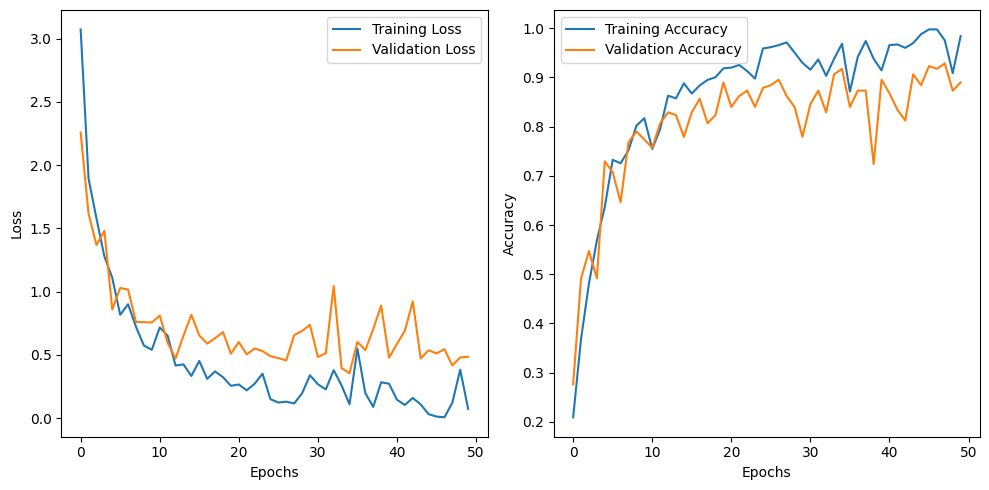

In [ ]:
plot_history(ANN_Results)

In [ ]:
show_evaluation_parameters(X_test, y_test, ANN_Model, num_labels, encoder)

Accuracy score :  0.8895027624309392
Precision score:  0.9069104596506078
Recall score   :  0.8895027624309392
F1 Score       :  0.8860390367572388

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.91      0.95      0.93        22
      bogura       1.00      0.96      0.98        25
  chottogram       0.90      0.82      0.86        22
    kurigram       0.95      0.90      0.92        20
   madaripur       1.00      1.00      1.00        16
 maymenshing       1.00      1.00      1.00         2
    noakhali       0.60      0.80      0.69        15
       pabna       0.89      1.00      0.94         8
 puran dhaka       0.95      0.95      0.95        19
    rajshahi       1.00      0.25      0.40         8
   shatkhira       1.00      1.00      1.00         4
      sylhet       0.43      0.60      0.50         5
  thakurgaon       0.94      1.00      0.97        15

    accuracy                           0.89    

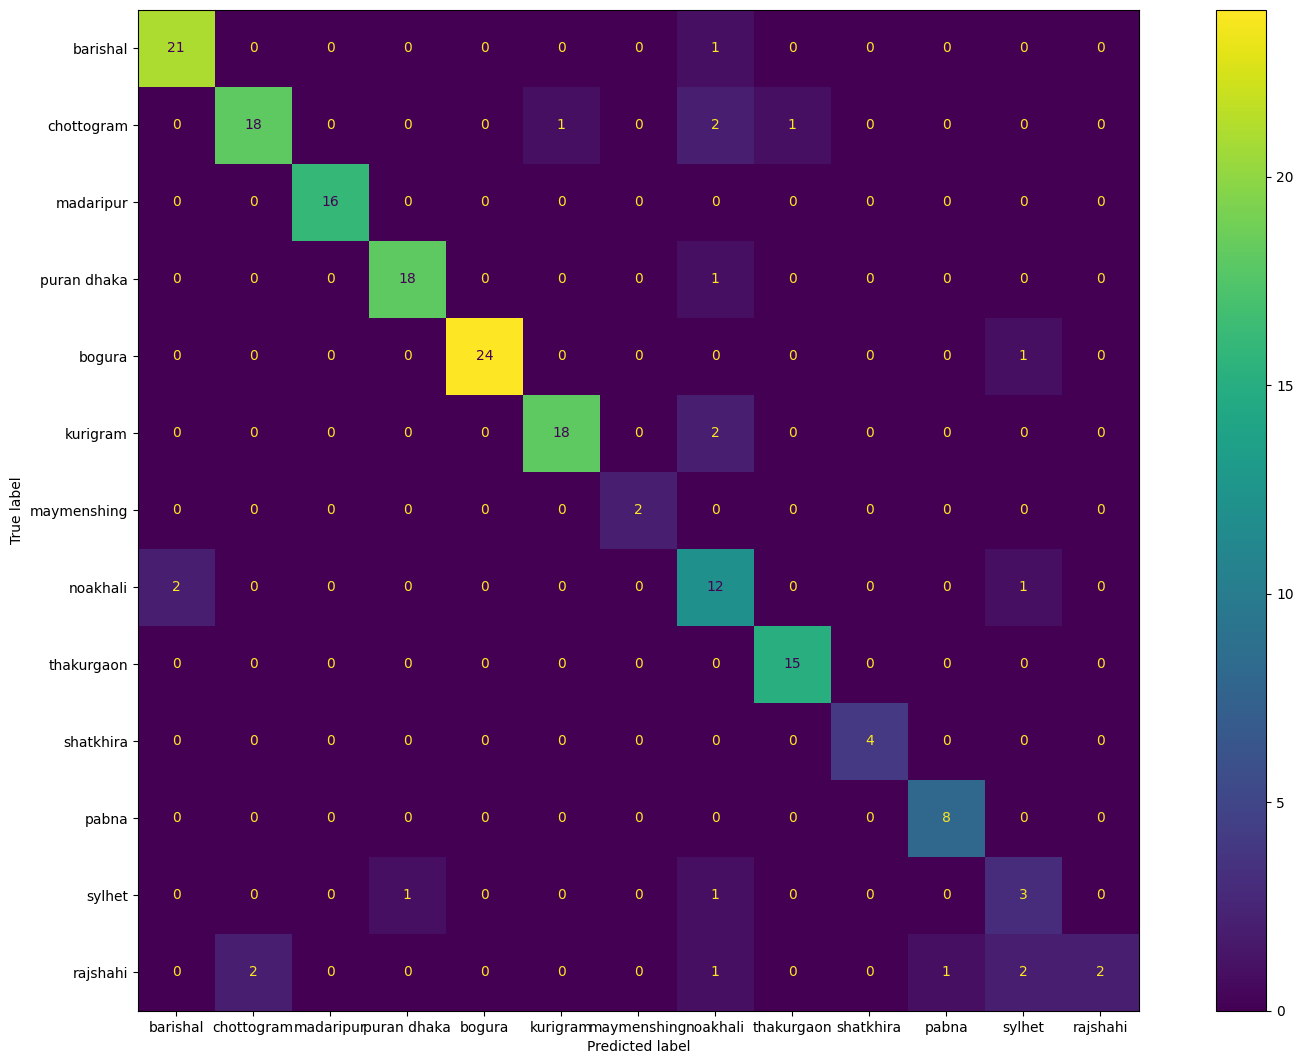

In [ ]:
show_confusion_matrix(X_test, y_test, ANN_Model, num_labels, encoder)

# Building CNN1D model

In [ ]:
CNN1D_Model = Sequential()
CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu", input_shape=(X_train.shape[1], 1),))
CNN1D_Model.add(BatchNormalization())
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(128, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(64, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Flatten())
CNN1D_Model.add(Dense(units=1024, activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(Dense(units=num_labels, activation="softmax"))

In [ ]:
CNN1D_Model.compile(optimizer="adam",
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

In [ ]:
CNN1D_Results = CNN1D_Model.fit(X_train,
                                y_train,
                                batch_size=5,
                                epochs=250,
                                validation_data=(X_test, y_test))

Epoch 1/250
145/145 [==============================] - 9s 11ms/step - loss: 2.7690 - accuracy: 0.1581 - val_loss: 2.3331 - val_accuracy: 0.3149
Epoch 2/250
145/145 [==============================] - 2s 10ms/step - loss: 2.2472 - accuracy: 0.2483 - val_loss: 2.0614 - val_accuracy: 0.2873
Epoch 3/250
145/145 [==============================] - 2s 11ms/step - loss: 2.0067 - accuracy: 0.3245 - val_loss: 2.0659 - val_accuracy: 0.3591
Epoch 4/250
145/145 [==============================] - 1s 8ms/step - loss: 1.8612 - accuracy: 0.3606 - val_loss: 1.9141 - val_accuracy: 0.3425
Epoch 5/250
145/145 [==============================] - 1s 7ms/step - loss: 1.7933 - accuracy: 0.3786 - val_loss: 1.8135 - val_accuracy: 0.3646
Epoch 6/250
145/145 [==============================] - 1s 7ms/step - loss: 1.7505 - accuracy: 0.4064 - val_loss: 1.8636 - val_accuracy: 0.3646
Epoch 7/250
145/145 [==============================] - 1s 7ms/step - loss: 1.6137 - accuracy: 0.4300 - val_loss: 1.7436 - val_accuracy: 0.4

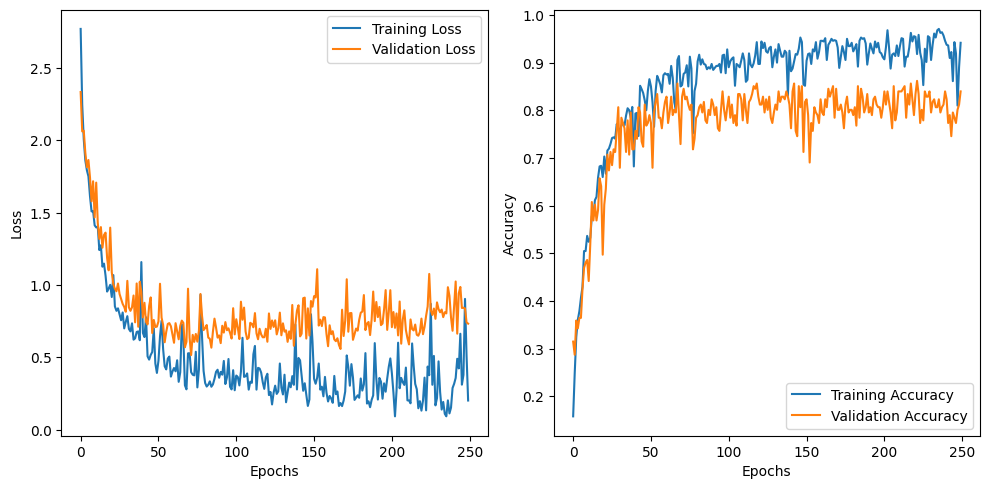

In [ ]:
plot_history(CNN1D_Results)

In [ ]:
show_evaluation_parameters(X_test, y_test, CNN1D_Model, num_labels, encoder)

Accuracy score :  0.8397790055248618
Precision score:  0.8613106987140138
Recall score   :  0.8397790055248618
F1 Score       :  0.8376432735130909

--------------------------------------------

              precision    recall  f1-score   support

    barishal       1.00      1.00      1.00        22
      bogura       0.92      0.96      0.94        25
  chottogram       0.63      0.77      0.69        22
    kurigram       0.94      0.75      0.83        20
   madaripur       1.00      1.00      1.00        16
 maymenshing       1.00      1.00      1.00         2
    noakhali       0.77      0.67      0.71        15
       pabna       0.75      0.75      0.75         8
 puran dhaka       0.72      0.95      0.82        19
    rajshahi       1.00      0.38      0.55         8
   shatkhira       0.67      1.00      0.80         4
      sylhet       0.67      0.80      0.73         5
  thakurgaon       1.00      0.73      0.85        15

    accuracy                           0.84    

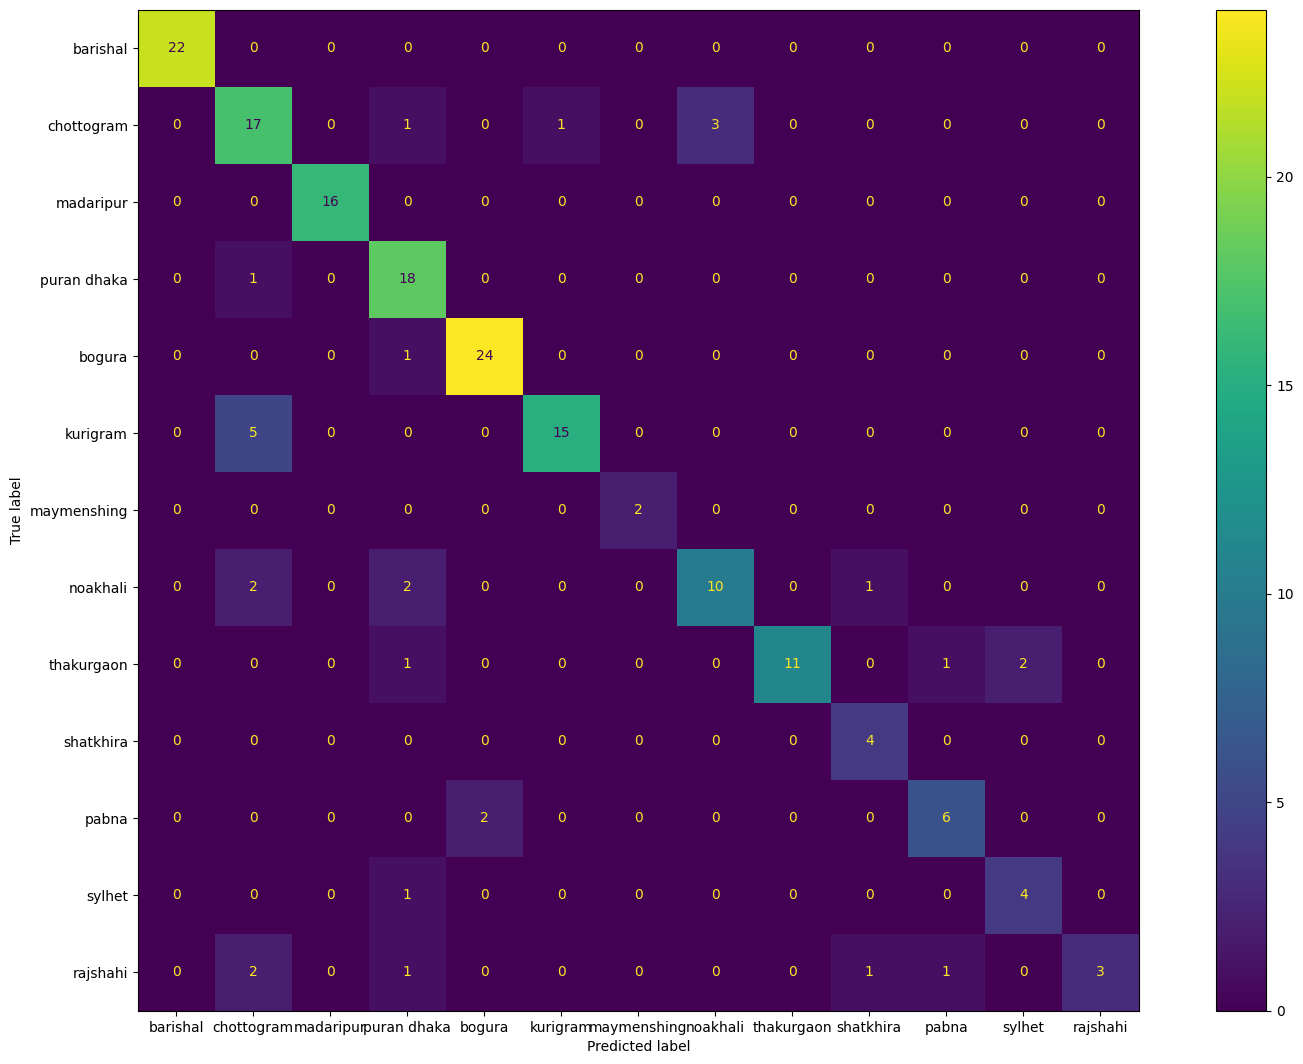

In [ ]:
show_confusion_matrix(X_test, y_test, CNN1D_Model, num_labels, encoder)

# Building CNN2D model

In [ ]:
# reshaping features to pass into the model
X_train_reshaped = X_train.reshape(X_train.shape[0], 16, 8, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 16, 8, 1)

In [ ]:
CNN2D_Model = Sequential()
CNN2D_Model.add(Conv2D(64, (3, 3), padding="same", activation="tanh", input_shape=(16, 8, 1)))
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Conv2D(128, (3, 3), padding="same", activation="tanh"))
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Dropout(0.1))
CNN2D_Model.add(Flatten())
CNN2D_Model.add(Dense(256, activation="tanh"))
CNN2D_Model.add(Dense(num_labels, activation="softmax"))

In [ ]:
CNN2D_Model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

In [ ]:
CNN2D_Results = CNN2D_Model.fit(X_train_reshaped,
                                y_train,
                                batch_size=5,
                                epochs=13,
                                validation_data=(X_test_reshaped, y_test))

Epoch 1/13
145/145 [==============================] - 3s 9ms/step - loss: 1.7597 - accuracy: 0.4563 - val_loss: 1.2388 - val_accuracy: 0.5580
Epoch 2/13
145/145 [==============================] - 1s 6ms/step - loss: 0.9485 - accuracy: 0.6879 - val_loss: 1.2945 - val_accuracy: 0.6133
Epoch 3/13
145/145 [==============================] - 1s 6ms/step - loss: 0.6469 - accuracy: 0.7961 - val_loss: 0.7381 - val_accuracy: 0.7624
Epoch 4/13
145/145 [==============================] - 1s 5ms/step - loss: 0.4161 - accuracy: 0.8655 - val_loss: 0.7891 - val_accuracy: 0.7845
Epoch 5/13
145/145 [==============================] - 1s 5ms/step - loss: 0.2438 - accuracy: 0.9307 - val_loss: 0.6710 - val_accuracy: 0.8287
Epoch 6/13
145/145 [==============================] - 1s 5ms/step - loss: 0.1811 - accuracy: 0.9473 - val_loss: 0.7840 - val_accuracy: 0.7680
Epoch 7/13
145/145 [==============================] - 1s 5ms/step - loss: 0.0914 - accuracy: 0.9764 - val_loss: 0.8128 - val_accuracy: 0.7680
Epoch 

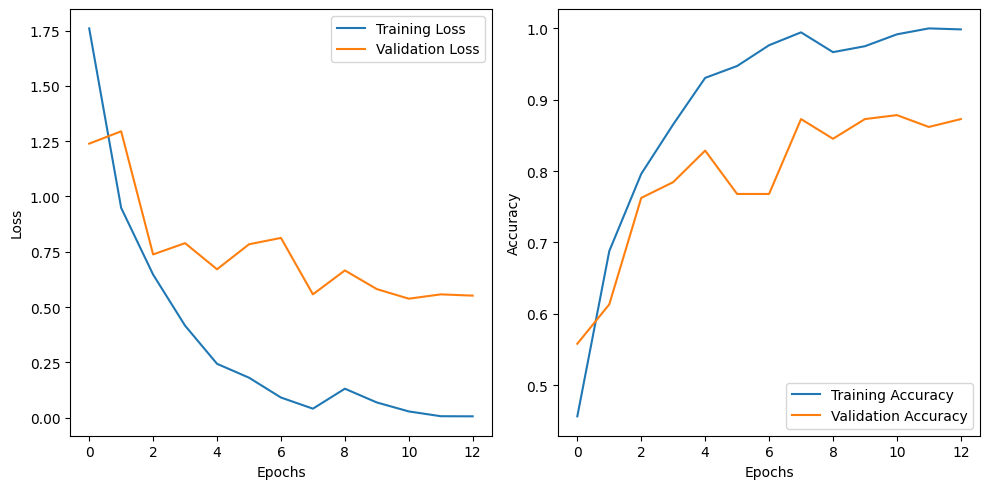

In [ ]:
plot_history(CNN2D_Results)

In [ ]:
show_evaluation_parameters(X_test_reshaped, y_test, CNN2D_Model, num_labels, encoder)

Accuracy score :  0.8729281767955801
Precision score:  0.8809670036026876
Recall score   :  0.8729281767955801
F1 Score       :  0.8747033761732299

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.95      0.95      0.95        22
      bogura       0.92      0.96      0.94        25
  chottogram       0.79      0.86      0.83        22
    kurigram       1.00      0.90      0.95        20
   madaripur       0.94      0.94      0.94        16
 maymenshing       1.00      1.00      1.00         2
    noakhali       0.65      0.73      0.69        15
       pabna       0.88      0.88      0.88         8
 puran dhaka       0.89      0.84      0.86        19
    rajshahi       0.83      0.62      0.71         8
   shatkhira       0.80      1.00      0.89         4
      sylhet       0.50      0.60      0.55         5
  thakurgaon       1.00      0.87      0.93        15

    accuracy                           0.87    

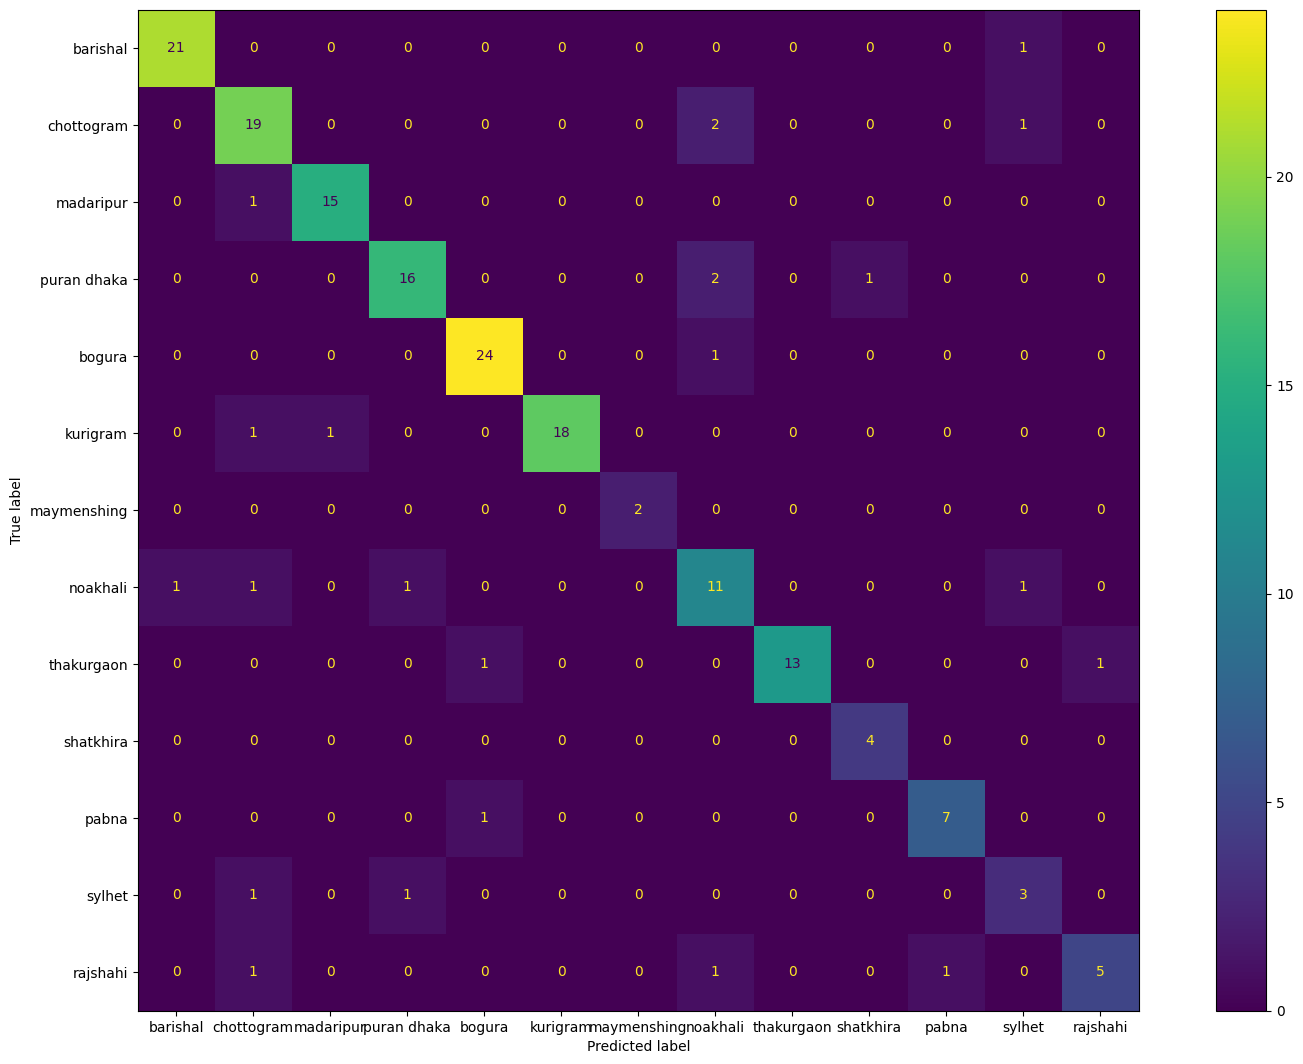

In [ ]:
show_confusion_matrix(X_test_reshaped, y_test, CNN2D_Model, num_labels, encoder)